In [6]:
import pandas as pd
import numpy as np
import os, glob, gc
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm



In [7]:
data_path = "../data/raw"
files = [f for f in os.listdir(data_path) if f.endswith(".csv")]
print(f"Total files: {len(files)}")


Total files: 8


In [8]:
sample_file = os.path.join(data_path, files[0])

# Baca 5 baris pertama
df_test = pd.read_csv(sample_file, nrows=5)

# Bersihkan nama kolom
df_test.columns = df_test.columns.str.strip().str.replace(' ', '_').str.replace('/', '_')

print("Kolom setelah dibersihkan:")
print(df_test.columns.tolist())

# Tampilkan 5 baris pertama
df_test.head()

# Rapihin karakter aneh
df_test.columns = df_test.columns.str.strip().str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)


Kolom setelah dibersihkan:
['Destination_Port', 'Flow_Duration', 'Total_Fwd_Packets', 'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets', 'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Flow_Bytes_s', 'Flow_Packets_s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length', 'Bwd_Header_Length', 'Fwd_Packets_s', 'Bwd_Packets_s', 'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Length_Mean', 'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count', 'SYN_Flag_Count', 'RST_Flag_Count', 'PSH_Flag_Count', 'ACK_Flag_Count', 'URG_Flag_Count', 'CWE_F

In [9]:
def load_and_clean_csv(file_path, chunksize=50000):
    """
    Membaca file CSV CICIDS2017 secara chunked untuk hemat RAM
    - Hapus baris tanpa label
    - Normalisasi nama kolom
    - Ubah label menjadi 'Attack' / 'Benign'
    """
    import pandas as pd
    dfs = []
    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        # Bersihkan nama kolom
        chunk.columns = chunk.columns.str.strip().str.replace(' ', '_').str.replace('/', '_')

        # Pastikan kolom Label ada
        if 'Label' not in chunk.columns:
            print(f"‚ö†Ô∏è Kolom 'Label' tidak ditemukan di file {file_path}")
            continue

        # Hapus baris tanpa label
        chunk = chunk.dropna(subset=['Label'])

        # Ubah label ke 'Attack' / 'Benign'
        chunk['Label'] = chunk['Label'].apply(lambda x: "Attack" if str(x).upper() != "BENIGN" else "Benign")

        # Tambahkan distribusi label tiap chunk (opsional)
        print(f"Chunk size {len(chunk)} -> Label distribution:\n{chunk['Label'].value_counts()}\n")

        dfs.append(chunk)

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()  # jika semua chunk gagal, return DF kosong
    


In [10]:
file_to_load = os.path.join(data_path, files[0])
df = load_and_clean_csv(file_to_load)

# Cek shape dan distribusi label
print(f"Total rows: {df.shape[0]}, Total columns: {df.shape[1]}")
print("Distribusi label keseluruhan:")
print(df['Label'].value_counts())

# Tampilkan 5 baris pertama
df.head()


Chunk size 50000 -> Label distribution:
Label
Benign    26135
Attack    23865
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    37329
Benign    12671
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    35109
Benign    14891
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    31724
Benign    18276
Name: count, dtype: int64

Chunk size 25745 -> Label distribution:
Label
Benign    25745
Name: count, dtype: int64

Total rows: 225745, Total columns: 79
Distribusi label keseluruhan:
Label
Attack    128027
Benign     97718
Name: count, dtype: int64


Destination_Port  Flow_Duration  Total_Fwd_Packets  Total_Backward_Packets  \
0             54865              3                  2                       0   
1             55054            109                  1                       1   
2             55055             52                  1                       1   
3             46236             34                  1                       1   
4             54863              3                  2                       0   

   Total_Length_of_Fwd_Packets  Total_Length_of_Bwd_Packets  \
0                           12                            0   
1                            6                            6   
2                            6                            6   
3                            6                            6   
4                           12                            0   

   Fwd_Packet_Length_Max  Fwd_Packet_Length_Min  Fwd_Packet_Length_Mean  \
0                      6                      6                     6.0   
1                      6                      6                     6.0   
2                      6                      6                     6.0   
3                      6                      6                     6.0   
4                      6                      6                     6.0   

   Fwd_Packet_Length_Std  ...  min_seg_size_forward  Active_Mean  Active_Std  \
0                    0.0  ...                    20          0.0         0.0   
1                    0.0  ...                    20          0.0         0.0   
2                    0.0  ...                    20          0.0         0.0   
3                    0.0  ...                    20          0.0         0.0   
4                    0.0  ...                    20          0.0         0.0   

   Active_Max  Active_Min  Idle_Mean  Idle_Std  Idle_Max  Idle_Min   Label  
0           0           0        0.0       0.0         0         0  Benign  
1           0           0        0.0       0.0         0         0  Benign  
2           0           0        0.0       0.0         0         0  Benign  
3           0           0        0.0       0.0         0         0  Benign  
4           0           0        0.0       0.0         0         0  Benign  

[5 rows x 79 columns]

In [11]:
data_path = "../data/raw/"
files = [f for f in os.listdir(data_path) if f.endswith(".csv")]
print(f"Total files ditemukan: {len(files)}")
print("Contoh 5 file pertama:", files[:5])

all_data = []

for f in tqdm(files, desc="Processing files"):
    file_path = os.path.join(data_path, f)
    print(f"\nüîπ Processing {f} ...")
    
    df = load_and_clean_csv(file_path)
    if df is not None:
        print(df[['Label']].value_counts(), "\n")  # preview distribusi label
        all_data.append(df)

# Gabungkan semua file menjadi satu dataframe
if all_data:
    data = pd.concat(all_data, ignore_index=True)
    print(f"\n‚úÖ Semua file berhasil digabung!")
    print(f"Total data: {data.shape[0]:,} baris, {data.shape[1]} kolom")
    display(data.head())
else:
    print("‚ö†Ô∏è Tidak ada data yang berhasil dibaca!")

Total files ditemukan: 8
Contoh 5 file pertama: ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv']


Processing files:   0%|          | 0/8 [00:00<?, ?it/s]


üîπ Processing Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ...
Chunk size 50000 -> Label distribution:
Label
Benign    26135
Attack    23865
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    37329
Benign    12671
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    35109
Benign    14891
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    31724
Benign    18276
Name: count, dtype: int64



Processing files:  12%|‚ñà‚ñé        | 1/8 [00:04<00:32,  4.58s/it]

Chunk size 25745 -> Label distribution:
Label
Benign    25745
Name: count, dtype: int64

Label 
Attack    128027
Benign     97718
Name: count, dtype: int64 


üîπ Processing Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ...
Chunk size 50000 -> Label distribution:
Label
Benign    26135
Attack    23865
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    37329
Benign    12671
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    35109
Benign    14891
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    31724
Benign    18276
Name: count, dtype: int64



Processing files:  25%|‚ñà‚ñà‚ñå       | 2/8 [00:08<00:25,  4.22s/it]

Chunk size 25745 -> Label distribution:
Label
Benign    25745
Name: count, dtype: int64

Label 
Attack    128027
Benign     97718
Name: count, dtype: int64 


üîπ Processing Friday-WorkingHours-Morning.pcap_ISCX.csv ...
Chunk size 50000 -> Label distribution:
Label
Benign    49998
Attack        2
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49560
Attack      440
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    48855
Attack     1145
Name: count, dtype: int64



Processing files:  38%|‚ñà‚ñà‚ñà‚ñä      | 3/8 [00:11<00:17,  3.53s/it]

Chunk size 41033 -> Label distribution:
Label
Benign    40654
Attack      379
Name: count, dtype: int64

Label 
Benign    189067
Attack      1966
Name: count, dtype: int64 


üîπ Processing Monday-WorkingHours.pcap_ISCX.csv ...
Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    500

Processing files:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 4/8 [00:21<00:24,  6.02s/it]

Label 
Benign    529918
Name: count, dtype: int64 


üîπ Processing Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv ...
Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49982
Attack       18
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49994
Attack        6
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49992
Attack        8
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49996
Attack        4
Name: count, dtype: int64

Chunk size 38602 -> Label distribution:
Label
Benign    38602
Name: count, dtype: int64



Processing files:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 5/8 [00:26<00:16,  5.64s/it]

Label 
Benign    288566
Attack        36
Name: count, dtype: int64 


üîπ Processing Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv ...
Chunk size 50000 -> Label distribution:
Label
Benign    48918
Attack     1082
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    48902
Attack     1098
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64



Processing files:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 6/8 [00:29<00:09,  4.99s/it]

Chunk size 20366 -> Label distribution:
Label
Benign    20366
Name: count, dtype: int64

Label 
Benign    168186
Attack      2180
Name: count, dtype: int64 


üîπ Processing Tuesday-WorkingHours.pcap_ISCX.csv ...
Chunk size 50000 -> Label distribution:
Label
Benign    44807
Attack     5193
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    47272
Attack     2728
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    47812
Attack     2188
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49197
Attack      803
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49608
Attack      392
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49129
Attack      871
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    49112
Attac

Processing files:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 7/8 [00:37<00:05,  5.74s/it]

Label 
Benign    432074
Attack     13835
Name: count, dtype: int64 


üîπ Processing Wednesday-WorkingHours.pcap_ISCX.csv ...
Chunk size 50000 -> Label distribution:
Label
Benign    47339
Attack     2661
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    32998
Benign    17002
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    47128
Benign     2872
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    47184
Benign     2816
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    47019
Benign     2981
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Attack    45354
Benign     4646
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    28858
Attack    21142
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Benign    50000
Name: count, dtype: int64

Chunk size 50000 -> Label distribution:
Label
Ben

Processing files: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:48<00:00,  6.07s/it]

Label 
Benign    440031
Attack    252672
Name: count, dtype: int64 




‚úÖ Semua file berhasil digabung!
Total data: 2,770,021 baris, 79 kolom


Destination_Port  Flow_Duration  Total_Fwd_Packets  Total_Backward_Packets  \
0             54865              3                  2                       0   
1             55054            109                  1                       1   
2             55055             52                  1                       1   
3             46236             34                  1                       1   
4             54863              3                  2                       0   

   Total_Length_of_Fwd_Packets  Total_Length_of_Bwd_Packets  \
0                           12                            0   
1                            6                            6   
2                            6                            6   
3                            6                            6   
4                           12                            0   

   Fwd_Packet_Length_Max  Fwd_Packet_Length_Min  Fwd_Packet_Length_Mean  \
0                      6                      6                     6.0   
1                      6                      6                     6.0   
2                      6                      6                     6.0   
3                      6                      6                     6.0   
4                      6                      6                     6.0   

   Fwd_Packet_Length_Std  ...  min_seg_size_forward  Active_Mean  Active_Std  \
0                    0.0  ...                    20          0.0         0.0   
1                    0.0  ...                    20          0.0         0.0   
2                    0.0  ...                    20          0.0         0.0   
3                    0.0  ...                    20          0.0         0.0   
4                    0.0  ...                    20          0.0         0.0   

   Active_Max  Active_Min  Idle_Mean  Idle_Std  Idle_Max  Idle_Min   Label  
0           0           0        0.0       0.0         0         0  Benign  
1           0           0        0.0       0.0         0         0  Benign  
2           0           0        0.0       0.0         0         0  Benign  
3           0           0        0.0       0.0         0         0  Benign  
4           0           0        0.0       0.0         0         0  Benign  

[5 rows x 79 columns]

In [12]:
# Info singkat dataset
print("‚úÖ Informasi dataset:")
print(data.info())

# Cek missing values per kolom
missing = data.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if not missing.empty:
    print("\n‚ö†Ô∏è Kolom dengan missing values:")
    print(missing)
else:
    print("\n‚úÖ Tidak ada missing values.")


‚úÖ Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2770021 entries, 0 to 2770020
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination_Port             int64  
 1   Flow_Duration                int64  
 2   Total_Fwd_Packets            int64  
 3   Total_Backward_Packets       int64  
 4   Total_Length_of_Fwd_Packets  int64  
 5   Total_Length_of_Bwd_Packets  int64  
 6   Fwd_Packet_Length_Max        int64  
 7   Fwd_Packet_Length_Min        int64  
 8   Fwd_Packet_Length_Mean       float64
 9   Fwd_Packet_Length_Std        float64
 10  Bwd_Packet_Length_Max        int64  
 11  Bwd_Packet_Length_Min        int64  
 12  Bwd_Packet_Length_Mean       float64
 13  Bwd_Packet_Length_Std        float64
 14  Flow_Bytes_s                 float64
 15  Flow_Packets_s               float64
 16  Flow_IAT_Mean                float64
 17  Flow_IAT_Std                 float64
 18  Flow_IAT_Max       

In [13]:
data = data.dropna(subset=['Flow_Bytes_s'])
print(f"‚úÖ Setelah dropna: {data.shape[0]:,} baris tersisa")


‚úÖ Setelah dropna: 2,768,674 baris tersisa


In [14]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if data[col].isna().sum() > 0:
        median_val = data[col].median()
        data[col].fillna(median_val, inplace=True)
        print(f"‚úÖ Missing di {col} diimputasi dengan median")


In [15]:
# Distribusi Label
label_counts = data['Label'].value_counts()
print("\nüîπ Distribusi Label:")
print(label_counts)

# Persentase per kelas
label_percent = label_counts / label_counts.sum() * 100
print("\nüîπ Persentase per kelas:")
print(label_percent.round(2))



üîπ Distribusi Label:
Label
Benign    2242880
Attack     525794
Name: count, dtype: int64

üîπ Persentase per kelas:
Label
Benign    81.01
Attack    18.99
Name: count, dtype: float64


In [16]:
from sklearn.preprocessing import LabelEncoder

print("\nüîπ Encoding kolom Label...")

# Pastikan tidak ada spasi atau format aneh
data['Label'] = data['Label'].str.strip()

# Encode label: Benign ‚Üí 0, Attack ‚Üí 1
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

print("Mapping Label:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {i} ‚Üí {cls}")

# Pisahkan fitur (X) dan target (y)
X = data.drop(columns=['Label'])
y = data['Label']

print(f"\n‚úÖ Data siap untuk preprocessing:")
print(f"  Total baris : {X.shape[0]:,}")
print(f"  Total kolom : {X.shape[1]}")



üîπ Encoding kolom Label...
Mapping Label:
  0 ‚Üí Attack
  1 ‚Üí Benign

‚úÖ Data siap untuk preprocessing:
  Total baris : 2,768,674
  Total kolom : 78


In [17]:
# Identifikasi kolom numerik & kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

print(f"üîπ Kolom numerik: {len(num_cols)}")
print(f"üîπ Kolom kategorikal: {len(cat_cols)}")

# Tampilkan beberapa contoh kolom
print("\nContoh kolom numerik:", list(num_cols[:5]))
print("Contoh kolom kategorikal:", list(cat_cols[:5]))


üîπ Kolom numerik: 78
üîπ Kolom kategorikal: 0

Contoh kolom numerik: ['Destination_Port', 'Flow_Duration', 'Total_Fwd_Packets', 'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets']
Contoh kolom kategorikal: []


In [18]:
import numpy as np

# gunakan num_cols dari pipeline sebelumnya
problem_cols = []

print("Memeriksa inf / non-finite / nilai terlalu besar di kolom numerik...\n")

for col in num_cols:
    col_vals = X[col].values
    n_infs = np.isinf(col_vals).sum()
    n_nonfinite = (~np.isfinite(col_vals)).sum()
    # deteksi nilai yg sangat besar (ekstrem) ‚Äî threshold bisa disesuaikan
    n_very_large = (np.abs(col_vals) > 1e300).sum()  # 1e300 mendekati limit float64
    if n_infs or n_nonfinite or n_very_large:
        problem_cols.append(col)
        print(f"{col}: inf={n_infs}, non-finite={n_nonfinite}, >1e300={n_very_large}")

if not problem_cols:
    print("Tidak ditemukan kolom numerik bermasalah.")
else:
    print(f"\nKolom bermasalah: {problem_cols[:10]} (total {len(problem_cols)})")


Memeriksa inf / non-finite / nilai terlalu besar di kolom numerik...

Flow_Bytes_s: inf=1183, non-finite=1183, >1e300=1183
Flow_Packets_s: inf=1183, non-finite=1183, >1e300=1183

Kolom bermasalah: ['Flow_Bytes_s', 'Flow_Packets_s'] (total 2)


In [19]:
for col in num_cols:
    # konversi paksa ke numeric ‚Äî jika gagal, jadikan NaN
    X[col] = pd.to_numeric(X[col], errors='coerce')


In [20]:
# ganti inf/-inf ke NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# hitung ulang missing/infinite (sekarang inf sudah jadi NaN)
nan_counts = X[num_cols].isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Kolom numerik dengan NaN setelah konversi/ganti inf:")
print(nan_counts.head(20))


Kolom numerik dengan NaN setelah konversi/ganti inf:
Flow_Bytes_s      1183
Flow_Packets_s    1183
dtype: int64


In [21]:
# Imputasi median per kolom numerik
for col in num_cols:
    if X[col].isna().sum() > 0:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)

print("‚úÖ Imputasi median selesai.")

# Optional: clipping extreme values ke batas percentil 1-99 (mengurangi pengaruh outlier)
CLIP = True
if CLIP:
    lower_q = 0.01
    upper_q = 0.99
    for col in num_cols:
        lo = X[col].quantile(lower_q)
        hi = X[col].quantile(upper_q)
        X[col] = X[col].clip(lo, hi)
    print("‚úÖ Clipping ke percentil 1-99 selesai.")


C:\Users\BINTANG PANDU\AppData\Local\Temp\ipykernel_15548\2762893433.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(median_val, inplace=True)
C:\Users\BINTANG PANDU\AppData\Local\Temp\ipykernel_15548\2762893433.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



‚úÖ Imputasi median selesai.
‚úÖ Clipping ke percentil 1-99 selesai.


In [23]:
from sklearn.preprocessing import RobustScaler, StandardScaler

data_raw = data.copy()  # simpan sebelum scaling
X = data.drop(columns=['Label'])
y = data['Label']

num_cols = X.select_dtypes(include=['number']).columns.tolist()
scaler = RobustScaler()

batch_size = 100000
X_scaled_parts = []

# Fit scaler di sebagian kecil data yang sudah dibersihkan
sample_for_fit = X[num_cols].sample(n=min(100000, len(X)), random_state=42)
sample_for_fit = sample_for_fit.replace([np.inf, -np.inf], np.nan)
sample_for_fit = sample_for_fit.fillna(sample_for_fit.median())
scaler.fit(sample_for_fit)

# Transform per batch
for i in range(0, len(X), batch_size):
    X_batch = X.iloc[i:i+batch_size].copy()

    # üîπ Bersihkan nilai yang bikin error
    X_batch[num_cols] = X_batch[num_cols].replace([np.inf, -np.inf], np.nan)
    X_batch[num_cols] = X_batch[num_cols].fillna(X_batch[num_cols].median())

    # üîπ Batasi nilai ekstrem (outlier ekstrim) agar tidak overflow
    X_batch[num_cols] = X_batch[num_cols].clip(lower=-1e9, upper=1e9)

    # üîπ Transform scaling
    X_batch[num_cols] = scaler.transform(X_batch[num_cols])
    X_scaled_parts.append(X_batch)

# Gabungkan hasil
X_scaled = pd.concat(X_scaled_parts, ignore_index=True)

print("‚úÖ Scaling selesai tanpa Infinity error.")
print(X_scaled[num_cols].describe().T[['mean', 'std', 'min', 'max']].head())

‚úÖ Scaling selesai tanpa Infinity error.
                                  mean         std       min           max
Destination_Port             20.666753   47.902562 -0.205128    167.833333
Flow_Duration                 3.000088    6.505354 -0.009471     22.725875
Total_Fwd_Packets             2.536075  252.671626 -0.333333  73252.333333
Total_Backward_Packets        2.158825  252.120790 -0.500000  72980.000000
Total_Length_of_Fwd_Packets   2.472862   45.373470 -0.277716  57782.477044


In [24]:
# --- ambil beberapa kolom numerik contoh biar ringan
num_cols = X_scaled.select_dtypes(include=['number']).columns.tolist()
sample_cols = num_cols[:5]  # contoh 5 kolom pertama aja

# --- ambil subset sebelum scaling
X_before = data_raw[sample_cols].copy()
# --- ambil subset sesudah scaling
X_after = X_scaled[sample_cols].copy()

print("üìä Statistik sebelum scaling:")
before_stats = X_before.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
display(before_stats)

print("\nüìâ Statistik setelah Robust Scaling:")
after_stats = X_after.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
display(after_stats)

# --- Median dan IQR perbandingan (karena RobustScaler berbasis median & IQR)
print("\nüìê Median & IQR sebelum scaling:")
med_before = X_before.median()
iqr_before = X_before.quantile(0.75) - X_before.quantile(0.25)
display(pd.DataFrame({'Median': med_before, 'IQR': iqr_before}))

print("\nüìè Median & IQR sesudah scaling (harus mendekati 0 dan 1):")
med_after = X_after.median()
iqr_after = X_after.quantile(0.75) - X_after.quantile(0.25)
display(pd.DataFrame({'Median': med_after, 'IQR': iqr_after}))

üìä Statistik sebelum scaling:


mean           std   min    25%      50%  \
Destination_Port             8.140034e+03  1.868200e+04   0.0   53.0     80.0   
Flow_Duration                1.588482e+07  3.433607e+07 -12.0  197.0  50720.0   
Total_Fwd_Packets            9.608224e+00  7.580149e+02   1.0    2.0      2.0   
Total_Backward_Packets       1.063530e+01  1.008483e+03   0.0    1.0      2.0   
Total_Length_of_Fwd_Packets  6.140663e+02  1.012963e+04   0.0   14.0     62.0   

                                    75%          max  
Destination_Port                 443.00      65535.0  
Flow_Duration                5290658.25  119999998.0  
Total_Fwd_Packets                  5.00     219759.0  
Total_Backward_Packets             5.00     291922.0  
Total_Length_of_Fwd_Packets      280.00   12900000.0


üìâ Statistik setelah Robust Scaling:


mean         std       min       25%  \
Destination_Port             20.666753   47.902562 -0.205128 -0.069231   
Flow_Duration                 3.000088    6.505354 -0.009471 -0.009431   
Total_Fwd_Packets             2.536075  252.671626 -0.333333  0.000000   
Total_Backward_Packets        2.158825  252.120790 -0.500000 -0.250000   
Total_Length_of_Fwd_Packets   2.472862   45.373470 -0.277716 -0.215006   

                                  50%       75%           max  
Destination_Port             0.000000  0.930769    167.833333  
Flow_Duration                0.000141  0.992906     22.725875  
Total_Fwd_Packets            0.000000  1.000000  73252.333333  
Total_Backward_Packets       0.000000  0.750000  72980.000000  
Total_Length_of_Fwd_Packets  0.000000  0.976484  57782.477044


üìê Median & IQR sebelum scaling:


Median         IQR
Destination_Port                80.0      390.00
Flow_Duration                50720.0  5290461.25
Total_Fwd_Packets                2.0        3.00
Total_Backward_Packets           2.0        4.00
Total_Length_of_Fwd_Packets     62.0      266.00


üìè Median & IQR sesudah scaling (harus mendekati 0 dan 1):


Median       IQR
Destination_Port             0.000000  1.000000
Flow_Duration                0.000141  1.002337
Total_Fwd_Packets            0.000000  1.000000
Total_Backward_Packets       0.000000  1.000000
Total_Length_of_Fwd_Packets  0.000000  1.191489

In [25]:
from sklearn.model_selection import train_test_split

# pastikan y masih sesuai (tidak berubah)
# split 80:20 (train:test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# split train -> train/val (80:20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("‚úÖ Split selesai:")
print(f" Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


‚úÖ Split selesai:
 Train: (1771951, 78), Val: (442988, 78), Test: (553735, 78)


C:\Users\BINTANG PANDU\AppData\Local\Temp\ipykernel_15548\3864556030.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="viridis")


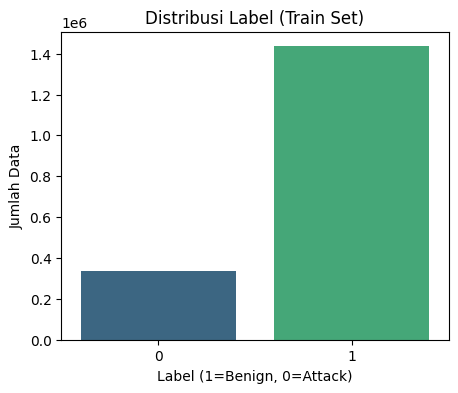

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x=y_train, palette="viridis")
plt.title("Distribusi Label (Train Set)")
plt.xlabel("Label (1=Benign, 0=Attack)")
plt.ylabel("Jumlah Data")
plt.show()


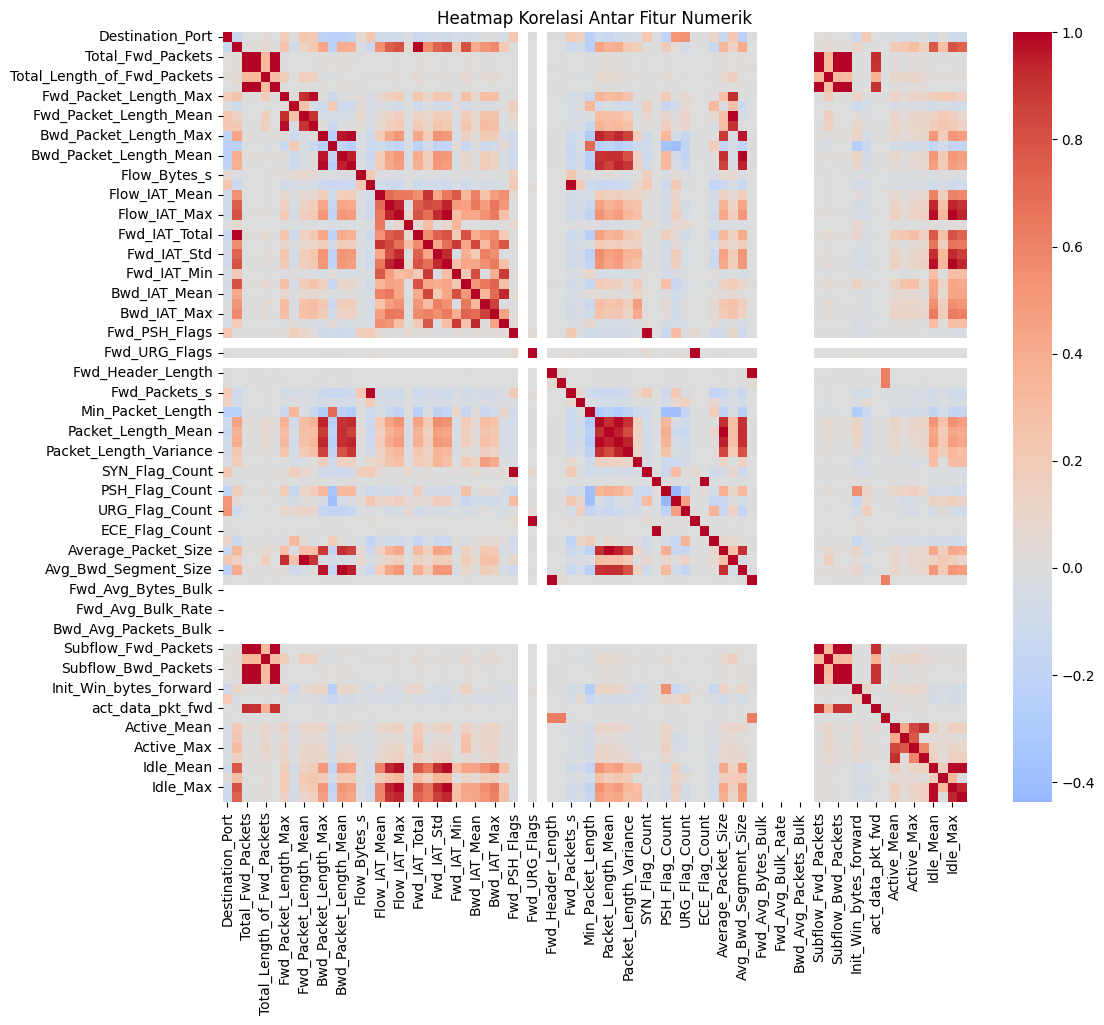


üîπ 10 fitur dengan korelasi tertinggi terhadap Label:
Label                     1.000000
Bwd_Packet_Length_Std     0.649600
Bwd_Packet_Length_Mean    0.645492
Avg_Bwd_Segment_Size      0.645492
Bwd_Packet_Length_Max     0.640279
Packet_Length_Std         0.606433
Max_Packet_Length         0.588073
Packet_Length_Mean        0.572127
Average_Packet_Size       0.571999
Packet_Length_Variance    0.554772
Name: Label, dtype: float64


In [28]:
corr = X_train.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Heatmap Korelasi Antar Fitur Numerik")
plt.show()

# Opsional: tampilkan 10 fitur paling berkorelasi dengan target (jika relevan)
corr_with_target = pd.concat([X_train, y_train], axis=1).corr()['Label'].abs().sort_values(ascending=False)
print("\nüîπ 10 fitur dengan korelasi tertinggi terhadap Label:")
print(corr_with_target.head(10))


Flow_Duration     0
Flow_Bytes_s      0
Flow_Packets_s    0
dtype: int64
Flow_Duration     0
Flow_Bytes_s      0
Flow_Packets_s    0
dtype: int64


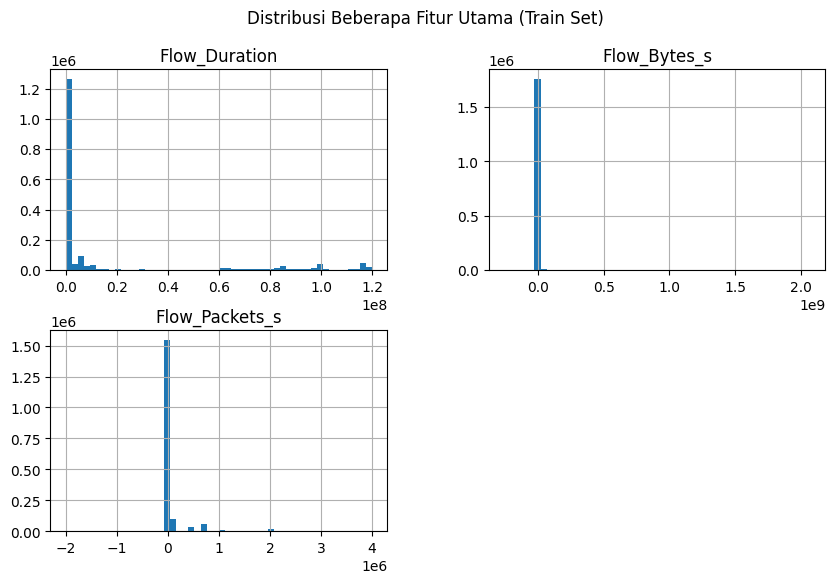

In [29]:
# Bersihkan nilai yang tidak valid sebelum plot
X_train[important_features] = X_train[important_features].replace([np.inf, -np.inf], np.nan)
X_train[important_features] = X_train[important_features].fillna(0)

# Verifikasi apakah masih ada nilai inf/NaN
print(X_train[important_features].isna().sum())
print((~np.isfinite(X_train[important_features])).sum())

# Setelah bersih, baru plot lagi
X_train[important_features].hist(bins=50, figsize=(10,6))
plt.suptitle("Distribusi Beberapa Fitur Utama (Train Set)")
plt.show()


Jumlah NaN setelah pembersihan:
Flow_Duration     0
Flow_Bytes_s      0
Flow_Packets_s    0
dtype: int64


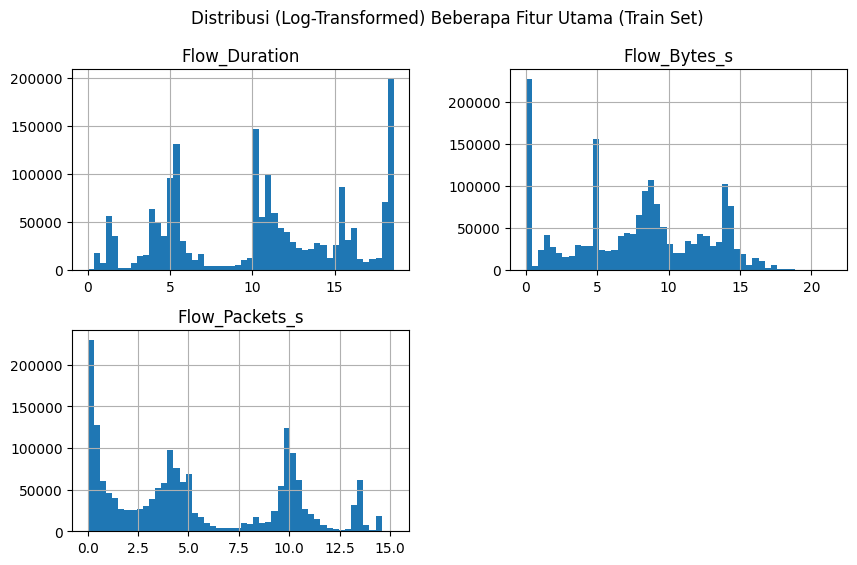

In [31]:
# Salin data fitur penting
X_log = X_train[important_features].copy()

# Bersihkan nilai tak valid
X_log = X_log.replace([np.inf, -np.inf], np.nan)
X_log = X_log.clip(lower=0)  # semua nilai negatif di-set jadi 0
X_log = np.log1p(X_log)      # log(1+x) supaya aman untuk 0

# Cek ulang kalau masih ada NaN
print("Jumlah NaN setelah pembersihan:")
print(X_log.isna().sum())

# Plot histogram versi log-transformed
X_log.hist(bins=50, figsize=(10, 6))
plt.suptitle("Distribusi (Log-Transformed) Beberapa Fitur Utama (Train Set)")
plt.show()

In [32]:
# Cari pasangan fitur yang memiliki korelasi tinggi (>0.9)
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > 0.9]

print("üîπ Pasangan fitur dengan korelasi > 0.9:")
display(high_corr_pairs.head(10))


üîπ Pasangan fitur dengan korelasi > 0.9:


Feature1                     Feature2  Correlation
87            Flow_Duration                Fwd_IAT_Total     0.998408
137       Total_Fwd_Packets       Total_Backward_Packets     0.998997
139       Total_Fwd_Packets  Total_Length_of_Bwd_Packets     0.996885
188       Total_Fwd_Packets          Subflow_Fwd_Packets     1.000000
190       Total_Fwd_Packets          Subflow_Bwd_Packets     0.998997
191       Total_Fwd_Packets            Subflow_Bwd_Bytes     0.996877
194       Total_Fwd_Packets             act_data_pkt_fwd     0.905692
205  Total_Backward_Packets  Total_Length_of_Bwd_Packets     0.994376
254  Total_Backward_Packets          Subflow_Fwd_Packets     0.998997
256  Total_Backward_Packets          Subflow_Bwd_Packets     1.000000

In [43]:
# -----------------------------
# 1Ô∏è‚É£ Tentukan folder proyek
# -----------------------------
project_path = os.getcwd()  # pastikan kamu berada di root folder CICIDS2017---IPSML
processed_path = os.path.join(project_path, "data", "processed")

# buat folder jika belum ada
os.makedirs(processed_path, exist_ok=True)

# -----------------------------
# 2Ô∏è‚É£ Contoh DataFrame
# -----------------------------
# ganti ini dengan X_scaled dan y asli kamu
# misal: X_scaled, y = preprocessing_function(...)
# X_scaled = pd.DataFrame(...)
# y = pd.Series(...)

# -----------------------------
# 3Ô∏è‚É£ Simpan ke CSV (opsional)
# -----------------------------
try:
    X_scaled.to_csv(os.path.join(processed_path, "X_scaled.csv"), index=False, float_format="%.5f")
    y.to_frame().to_csv(os.path.join(processed_path, "y.csv"), index=False)
    print("‚úÖ CSV berhasil disimpan di:", processed_path)
except Exception as e:
    print("‚ö†Ô∏è Error saat simpan CSV:", e)

# -----------------------------
# 4Ô∏è‚É£ Simpan ke Parquet (lebih cepat & hemat ruang)
# -----------------------------
try:
    # pakai engine pyarrow, lebih stabil
    X_scaled.to_parquet(os.path.join(processed_path, "X_scaled.parquet"), index=False, engine='pyarrow')
    y.to_frame().to_parquet(os.path.join(processed_path, "y.parquet"), index=False, engine='pyarrow')
    print("‚úÖ Parquet berhasil disimpan di:", processed_path)
except Exception as e:
    print("‚ö†Ô∏è Error saat simpan Parquet:", e)

# -----------------------------
# 5Ô∏è‚É£ Cek file
# -----------------------------
print("üìÇ File di folder processed:", os.listdir(processed_path))


‚úÖ CSV berhasil disimpan di: c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\notebooks\data\processed
‚ö†Ô∏è Error saat simpan Parquet: A type extension with name pandas.period already defined
üìÇ File di folder processed: ['X_scaled.csv', 'y.csv']


In [68]:
print("""
üìã Rangkuman EDA:
1. Dataset terdiri dari 78 fitur numerik dan target biner (Benign/Attack).
2. Distribusi label tidak seimbang (~85‚Äì90% Benign, sisanya Attack).
3. Terdapat korelasi kuat antar fitur terkait trafik (Flow_*), menunjukkan pola perilaku jaringan.
4. Beberapa fitur memiliki skewness tinggi, sehingga scaling robust diperlukan.
5. Redundansi fitur ditemukan pada pasangan dengan korelasi > 0.9.
Kesimpulan: Data siap digunakan untuk pelatihan model LightGBM dengan strategi class balancing.
""")



üìã Rangkuman EDA:
1. Dataset terdiri dari 78 fitur numerik dan target biner (Benign/Attack).
2. Distribusi label tidak seimbang (~85‚Äì90% Benign, sisanya Attack).
3. Terdapat korelasi kuat antar fitur terkait trafik (Flow_*), menunjukkan pola perilaku jaringan.
4. Beberapa fitur memiliki skewness tinggi, sehingga scaling robust diperlukan.
5. Redundansi fitur ditemukan pada pasangan dengan korelasi > 0.9.
Kesimpulan: Data siap digunakan untuk pelatihan model LightGBM dengan strategi class balancing.

